<a href="https://colab.research.google.com/github/aref-shabani/DK_sales_forecasting/blob/master/Copy_of_DK_sales_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Digikala product forecast
In this kernel we will read the dataset of Digikala which have information about sell history of products. Digikala want to suggest products to sellers to make available.

### dataset contain:
id

date : information saved in this date

seller : seller id

item : product id

sales : number of sales of the product

## problem :
#### make predict of product based on sales history of products


#### Necessary library

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline
import matplotlib.pyplot as plt

#### Function: SMAPE, display_scores

In [ ]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [ ]:
def display_scores(scores):
  print("Scores:", scores)
  print("Mean:", scores.mean())
  print("Standard deviation:", scores.std())

#### Read files

In [ ]:
# when run this notebook in Google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_path = '/content/drive/My Drive/Colab Notebooks/train.csv'
train = pd.read_csv(train_path)

test_path = '/content/drive/My Drive/Colab Notebooks/test.csv'
test = pd.read_csv(test_path)

In [ ]:
#train = pd.read_csv('Dataset/train.csv')
#test = pd.read_csv('Dataset/test.csv')


In [ ]:
train.head()

,id,date,seller,item,sales
0,0,2015-05-01,1,1,21
1,1,2015-05-01,2,1,45
2,2,2015-05-01,3,1,28
3,3,2015-05-01,4,1,34
4,4,2015-05-01,5,1,21


In [ ]:
test.head()

,id,date,seller,item
0,0,2020-04-04,1,1
1,1,2020-04-04,2,1
2,2,2020-04-04,3,1
3,3,2020-04-04,4,1
4,4,2020-04-04,5,1


In [ ]:
# set index column as index in train file and test file
train.set_index('id', inplace=True)
test.set_index('id', inplace=True)

#### Review our data

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900000 entries, 0 to 899999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    900000 non-null  object
 1   seller  900000 non-null  int64 
 2   item    900000 non-null  int64 
 3   sales   900000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 34.3+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13000 entries, 0 to 12999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    13000 non-null  object
 1   seller  13000 non-null  int64 
 2   item    13000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 406.2+ KB


## looking for null, Nan or non relative input in rows

In [ ]:
train.isnull().sum()

date      0
seller    0
item      0
sales     0
dtype: int64

In [ ]:
test.isnull().sum()

date      0
seller    0
item      0
dtype: int64

In [ ]:
train.seller.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
test.seller.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
train.item.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
test.item.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [ ]:
train.sales.unique()

array([ 21,  45,  28,  34,  27,  25,  26,  37,  32,  22,  20,  35,  38,
        24,  40,  33,  11,  29,  39,  17,  30,  53,  47,  41,  46,  16,
        14,  43,  19,  44,  23,  18,  42,  15,  31,  36,  48,   8,  13,
         9,  49,  12,  51,  55,  52,  57,  56,  62,  59,  54,  61,  58,
        60,  50,  64,  63,  75,  66,  82,  72,  70,  76,  67,  78,  68,
        77,  65,  74,  73,  84,  71,  69,  81,  80,  91,  79,  93,  83,
        87,  98,  85, 100,  90,  94,  86,  88,  89,  95,  92, 105,  97,
       102,  96, 103, 113, 106,  99, 109, 107, 104, 108, 110, 101, 120,
       117, 116, 114, 115, 126, 118, 112, 119, 111, 123, 130, 128, 124,
        10,   7,   3,   5,   6,   4, 121, 122, 127, 132, 125, 129, 143,
       131, 133, 134, 138, 153, 150, 148, 141, 140, 152, 135, 139, 136,
       137, 144, 149, 142, 157, 164, 161, 147, 154, 145,   2,   1,   0,
       169, 156, 159, 155, 163, 165, 146, 160, 158, 151, 162, 171, 168,
       177, 167, 166, 175, 176, 181, 174, 170, 178, 172, 173, 18

## Preparing Data

In [ ]:
# change date columns to date type
train.date = pd.to_datetime(train['date'])
test.date = pd.to_datetime(test['date'])

In [ ]:
# add day and month columns in train data
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month


train = train.drop('date', axis=1)

# add day and month columns in test data
test['day'] = test['date'].dt.day
test['month'] = test['date'].dt.month


test = test.drop('date', axis=1)

In [ ]:
train.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31])

In [ ]:
test.day.unique()

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29])

In [ ]:
train.month.unique()

array([ 5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4])

In [ ]:
test.month.unique()

array([4])

In [ ]:
train.head()

,seller,item,sales,day,month
id,,,,,
0,1,1,21,1,5
1,2,1,45,1,5
2,3,1,28,1,5
3,4,1,34,1,5
4,5,1,21,1,5


In [ ]:
item_sales = train.groupby('item').sales.mean()
item_sales.sort_values(ascending=False)

item
18    88.212778
31    88.072111
16    84.481500
21    84.450667
28    80.849833
48    80.754333
41    80.677222
25    80.667778
39    77.181722
11    77.104778
13    73.378056
14    69.779167
15    69.778389
32    69.754667
36    69.711944
27    66.177833
3     66.029333
38    65.938167
17    58.799944
34    58.760444
49    58.750944
5     58.685722
10    58.648278
9     58.622778
12    51.498722
1     51.451722
46    51.393444
29    47.744889
23    47.610833
35    44.073556
42    43.975278
22    40.442444
33    40.425556
24    40.403556
45    36.769889
6     36.709167
20    33.065222
47    29.459722
2     29.403556
26    29.355611
40    29.315556
43    29.310389
37    25.787222
19    25.718722
30    22.097222
7     22.059722
44    22.052500
50    22.047500
4     22.028278
8     18.388667
Name: sales, dtype: float64

In [ ]:
month_sales = train.groupby('month').sales.mean()
month_sales.sort_values(ascending=False)

month
11    66.280067
10    63.656619
9     59.344947
12    58.700839
8     55.539458
1     54.842039
3     54.148529
2     51.272155
7     47.982516
6     39.932080
4     38.214878
5     35.634671
Name: sales, dtype: float64

In [ ]:
corr_matrix = train.corr()
corr_matrix['sales'].sort_values(ascending=False)

sales     1.000000
month     0.170869
day       0.003272
seller   -0.008123
item     -0.031485
Name: sales, dtype: float64

In [ ]:
day_sales = train.groupby('day').sales.mean()
day_sales.sort_values(ascending=False)

day
29    53.035286
4     52.853525
18    52.807864
11    52.794542
25    52.780746
13    52.660610
6     52.591661
20    52.582542
27    52.551322
30    52.483556
28    52.417492
26    52.357220
16    52.335458
24    52.326881
17    52.318644
19    52.308068
10    52.293593
12    52.290881
31    52.283486
23    52.273797
9     52.206814
5     52.206780
8     52.104305
1     52.097133
15    52.059864
22    52.054983
14    52.053051
3     52.038900
21    51.997797
7     51.992678
2     51.944100
Name: sales, dtype: float64

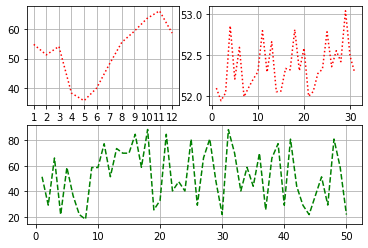

In [ ]:
plt.subplot(212)
plt.plot(item_sales,'g--')
plt.grid(True)
plt.subplot(221)
plt.plot(month_sales,'r:')
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12])
plt.grid(True)
plt.subplot(222)
plt.plot(day_sales,'r:')
plt.grid(True)
plt.show()

## Create Test set

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [ ]:
for train_index, test_index in split.split(train, train['month']):
    strat_trian_set = train.loc[train_index]
    strat_test_set = train.loc[test_index]

In [ ]:
X = strat_trian_set.drop('sales', axis=1)
y = strat_trian_set.sales.copy()

In [ ]:
some_data = X.iloc[:5]
some_labels = y.iloc[:5]

# Modeling

## Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()

In [ ]:
lin_reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:

lin_pred = lin_reg.predict(some_data)
print("prediction:", lin_pred)

prediction: [43.17176752 46.45652738 51.28088856 61.60767197 51.61729511]


In [ ]:
print("Labels: ", list(some_labels))

Labels:  [33, 22, 17, 99, 49]


In [ ]:
smape(some_labels,lin_pred)

50.06722488981762

In [ ]:
# last error = 47.423, 50.067

In [ ]:
print(np.sqrt(mean_squared_error(some_labels, lin_pred)))

25.619532922046965


In [ ]:
# last error = 44.968, 25.619

## Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(max_depth=25,min_samples_leaf=7,random_state=42)

In [ ]:
tree_reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=25,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=7, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [ ]:
tree_pred = tree_reg.predict(some_data)
print("prediction Decision Tree:", tree_pred)

prediction Decision Tree: [26.77777778 29.21428571 23.125      99.28571429 46.5       ]


In [ ]:
print("Labels: ", list(some_labels))

Labels:  [33, 22, 17, 99, 49]


In [ ]:
print(np.sqrt(mean_squared_error(some_labels, tree_pred)))

5.188626511961026


In [ ]:
# last error = 15.728 , 6.36, 5.957, 5.188,

In [ ]:
smape(some_labels,tree_pred)

17.00883364626456

In [ ]:
# last error = 17.008 , 21.850

### Cross Validation score

In [ ]:
scores = cross_val_score(tree_reg, X, y,
                        scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)

In [ ]:
display_scores(tree_rmse_scores)

Scores: [13.06615065 13.0425138  13.07811677 13.06199237 13.09035204]
Mean: 13.067825127304669
Standard deviation: 0.016067780178288436


## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
forest_reg = RandomForestRegressor(random_state=42)

In [ ]:
forest_reg.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
forest_pred = forest_reg.predict(some_data)

In [ ]:
print("prediction Decision Tree:", forest_pred)

prediction Decision Tree: [26.1364798  30.56190043 24.09986508 94.49142532 47.03986508]


In [ ]:
print("Labels: ", list(some_labels))

Labels:  [33, 22, 17, 99, 49]


In [ ]:
print(np.sqrt(mean_squared_error(some_labels,forest_pred)))

6.244862003946916


In [ ]:
# last error = 14.5823, 6.35, 6.40, 6.244

In [ ]:
smape(some_labels,forest_pred)

19.816462625808143

In [ ]:
# last error = 22.1139, 19.816

### Cross Validation score

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
scores = cross_val_score(forest_reg, X, y,
                        scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-scores)



In [ ]:
display_scores(forest_rmse_scores)

Scores: [14.53965917 14.54176831 14.55168992 14.55162419 14.57915762]
Mean: 14.552779842130303
Standard deviation: 0.01408344271099837


In [ ]:
# Feature Importance
for name, score in zip(X.columns, forest_reg.feature_importances_):
    print(name, score)

seller 0.17400964032490265
item 0.6349648433892411
day 0.062138503649429924
month 0.12888701263642632


## **SVM**

In [ ]:
from sklearn.svm import LinearSVR
svr_reg = LinearSVR(random_state=42, epsilon=1)

In [ ]:
scaler = StandardScaler()
X_scaler = scaler.fit_transform(X)
# scaler in LinearSVR affect on result

In [ ]:
svr_reg.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [ ]:
svr_pred = svr_reg.predict(some_data)

In [ ]:
print(np.sqrt(mean_squared_error(some_labels, svr_pred)))

24.363687036059908


In [ ]:
# last error: 24.061, 46.504, 20.772

In [ ]:
smape(some_labels, svr_pred)

44.157667265720434

In [ ]:
# last error: 43.304, 48.120, 38.910

### Randomized Search CV

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [ ]:
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_scaler, y)

In [ ]:
rnd_search_pred = rnd_search_cv.predict(some_data)

In [ ]:
print(np.sqrt(mean_squared_error(some_labels, rnd_search_pred)))

In [ ]:
# last error: 

In [ ]:
smape(some_labels, rnd_search_pred)

In [ ]:
# last error: 

## XGRegressor

In [ ]:
from xgboost import XGBRegressor
xg_reg = XGBRegressor(random_state=42)

In [ ]:
xg_reg.fit(X,y)

[08:14:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
xgb_pred = xg_reg.predict(some_data)
print("prediction XGBRegressor:", xgb_pred)

prediction XGBRegressor: [34.136402 43.40447  31.066113 68.79671  45.223118]


In [ ]:
print("Labels: ", list(some_labels))

Labels:  [33, 22, 17, 99, 49]


In [ ]:
print(np.sqrt(mean_squared_error(some_labels, xgb_pred)))

17.797763579868995


In [ ]:
# Last Error: 17.7977

In [ ]:
smape(some_labels,xgb_pred)

34.27658284948385

In [ ]:
# Last Error : 34.2765